In [ ]:
from pathlib import Path

from preprocessing import Preprocessor
from preprocessing import load_files
# with Path('../functions/'):
#     from create_previous_images import create_early_image_2
#     from generators import image_generator
#     from unet_model import unet
# from statistics_birds_test import pipeline, create_ERROR_images_on_radar
# import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

from PIL import Image
from skimage.measure import block_reduce

# import rpy2.robjects as ro
# from rpy2.robjects import r
# from rpy2.robjects.packages import importr

In [ ]:
with Path('..'):
    files = load_files()

In [4]:
# preprocess the files
with Path('..'):
    input, y_test, files_index = Preprocessor(files[0])

190it [00:18, 10.49it/s]


In [5]:
import torch
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
from pytorch.unet.unet_model import UNet

model = UNet(n_channels=9, n_classes=1)
checkpoint_path = "/home/theator/ziv/code/birds/pytorch/logs/lr=0.001;threshold=0.5;sep_sites/version_0/checkpoints/epoch=9-step=1960.ckpt"
w = torch.load(checkpoint_path)
consume_prefix_in_state_dict_if_present(w['state_dict'], prefix="model.")
model.load_state_dict(w['state_dict'])
model = model.to("cuda:0")

In [6]:
model.eval()
with torch.no_grad():
    predict = model(torch.from_numpy(input).permute(0, 3, 1, 2).to(device="cuda:0", dtype=torch.float32))

In [7]:
predict[predict <= 0.2] = 0
predict[predict > 0.2] = 255

In [8]:
pred = predict[:, :, :, 0].clone()

<h2>Ellipses

In [9]:
def dilate_cont(img,
                cont):  # this function finds contours for smaller predictions that dont have enough length for a contour

    msk = create_contour_mask(img, cont)
    # dilate mask
    msk = cv2.dilate(msk, (2, 2), iterations=1)

    im = img.copy()
    # apply mask to image
    im = (np.uint8(im / 255) & np.uint8(msk / 255)) * 255
    # dilate image
    im = cv2.dilate(im, (2, 2), iterations=1)

    # find "constructed" contours
    contours_raw = create_target_contours(np.uint8(im))

    contours = []
    for cont in contours_raw:
        if len(cont) > 5:
            contours.append(cont)

    return contours


def create_contour_mask(img, cont):  # create a mask with only the specific contour

    msk = img.copy()

    # delete everything outside chosen contour
    msk = cv2.cvtColor(np.uint8(msk), cv2.COLOR_GRAY2RGB)

    msk = cv2.drawContours(msk, [cont], 0, (254, 254, 254), 1)  # draw the contour needed to break

    msk[msk == 255] = 0  # delete everything except the contour

    # TODO: might be issues because of the starting point of the fill at (0,0) - use skimage grid point in poly
    msk = cv2.floodFill(np.uint8(msk), None, (0, 0),
                        (127, 127, 127))  # fill everything except the contour and its insides with gray
    msk = msk[1]  # take the image

    msk[msk == 0] = 255  # make the inside of the contour white
    msk[msk == 254] = 255  # make the contour white
    msk[msk == 127] = 0  # make everything else black
    msk = cv2.cvtColor(msk, cv2.COLOR_RGB2GRAY)  # turn into grayscale again

    return msk


def break_minor_cont(img, cont):  # this function finds even more subtle contours by eroding and then pixelating

    msk = create_contour_mask(img, cont)  # create a mask with only the specific contour

    im = img.copy()
    # apply mask to image
    im = (np.uint8(im / 255) & np.uint8(msk / 255)) * 255

    # erode the image
    kernel = np.ones((2, 2), np.uint8)
    im = cv2.erode(im, kernel, iterations=1)

    # pixelate the image
    block_size = (2, 2)
    im = block_reduce(im, block_size=block_size, func=np.mean)
    im = np.array(Image.fromarray(im).resize((256, 256), Image.NEAREST))

    # apply cutoff
    im[im > 150] = 255
    im[im <= 150] = 0

    # Image.fromarray(cv2.cvtColor(np.uint8(im), cv2.COLOR_GRAY2RGB)).save("test"+str(len(cont))+".jpeg")

    # find broken contours
    contours = create_target_contours(np.uint8(im))

    return contours


def break_major_cont(img, cont):  # this function finds more subtle contoutrs because it's not pixelated

    msk = create_contour_mask(img, cont)  # create a mask with only the specific contour

    im = img.copy()

    # apply mask to image
    im = (np.uint8(im / 255) & np.uint8(msk / 255)) * 255

    # find broken contours
    contours_raw = create_target_contours(np.uint8(im))

    contours = []
    for cont in contours_raw:
        if cv2.contourArea(cont) < 40:  # check for left unbroken contours
            contours.append(cont)
        else:
            minor_broken_conts = break_minor_cont(img, cont)
            for mcont in minor_broken_conts:
                contours.append(mcont)

    return contours


def create_ellipse(cont):
    (x, y), (MA, ma), angle = cv2.fitEllipse(cont)
    Area = math.pi * MA * ma

    return [int(x), int(y), int(MA), int(ma), int(angle), int(Area)]


def create_target_contours(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    return contours


def preprocess_rad(rad, pred):
    rad_temp = rad.copy()

    # dilate pred mask
    kernel = np.ones((2, 2), np.uint8)
    pred_temp = cv2.dilate(pred, kernel, iterations=1)

    # remove all gray
    msk = (rad_temp > 125) & (rad_temp < 129)
    rad_temp[msk] = 255

    # put pred mask on radar image
    masked_rad = np.dstack((rad_temp, np.uint8(pred_temp)))
    masked_rad[masked_rad[:, :, 3] == 0] = 255
    masked_rad = masked_rad[:, :, 0:3]

    # turn radar image to grayscale
    gray_rad = cv2.cvtColor(masked_rad, cv2.COLOR_RGB2GRAY)

    # make all grays whites
    gray_rad[gray_rad < 255] = 0

    # flip color
    gray_rad = 255. - gray_rad

    return gray_rad


def create_target_ellipses(rad, pred):  # TODO: do it
    # preprocess the radar image
    img = preprocess_rad(np.uint8(rad * 255), pred)  # preprocess the radar image
    #img=rad.copy()
    # pixelate the image to find roughly most contours
    block_size = (2, 2)
    px_rad = np.uint8(block_reduce(img, block_size=block_size, func=np.mean))
    px_rad = np.array(Image.fromarray(px_rad).resize((256, 256), Image.NEAREST))
    # px_rad = np.uint8(img.copy())
    ellipses = []
    target_contours = create_target_contours(px_rad)

    for cont in target_contours:
        if len(cont) > 5:
            if cv2.contourArea(cont) < 40:  # check if contour is not too big
                ellipses.append(create_ellipse(cont))  # fit an ellipse to each contour
            else:
                broken_conts = break_major_cont(img, cont)  # if the contour is too big, break it up
                for bcont in broken_conts:
                    if len(bcont) > 5:
                        ellipses.append(create_ellipse(bcont))
                    else:
                        dilated_conts = dilate_cont(img,
                                                    bcont)  # if the contour is too small, dilate the original image to fit an ellipse
                        for dcont in dilated_conts:
                            ellipses.append(create_ellipse(dcont))
        else:
            dilated_conts = dilate_cont(img, cont)  # again, for the possibility of a contour which is too small
            for dcont in dilated_conts:
                ellipses.append(create_ellipse(dcont))

    return ellipses


def find_ellipses(arr):
    ellipses = []
    for i, im in enumerate(arr):
        temp_el = create_target_ellipses(input[i, :, :, 0:3], im)
        ellipses.append(temp_el)
    return ellipses


def put_ellipse_centers(arr, ellipses):
    temp_arr = [cv2.cvtColor(x.copy(), cv2.COLOR_BGR2RGB) for x in arr]
    for i, ell in enumerate(ellipses):
        if i + 2 >= len(temp_arr):
            break
        for el in ell:
            cv2.circle(temp_arr[i], (el[0], el[1]), 3, (0, 0, 255), -1)
    return temp_arr

In [10]:
def stack(arr):
    stacked = []
    for i, im in enumerate(arr):
        if i + 2 >= arr.shape[0]:
            break

        stacked.append(im)
        stacked[i] = np.add(stacked[i], arr[i + 1])
        stacked[i] = np.add(stacked[i], arr[i + 2])
        # cutoff
        stacked[i][stacked[i] <= 256] = 0
        stacked[i][stacked[i] > 256] = 255
    return np.array(stacked)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


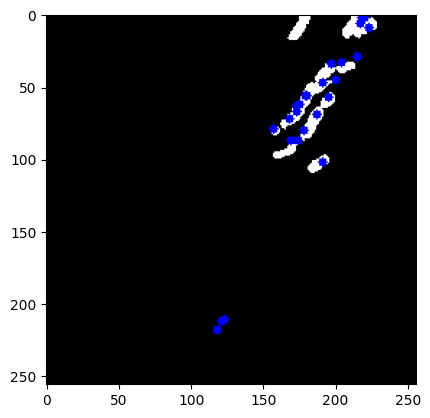

In [11]:
predict_numpy = predict.squeeze().cpu().numpy()
ellipses = find_ellipses(predict_numpy)
out_pred_ell = put_ellipse_centers(stack(predict_numpy), ellipses)
plt.imshow(out_pred_ell[0])

<h2> Centroids

In [12]:
def create_centroid(cont):
    M = cv2.moments(cont)
    if M['m00'] == 0:
        return [0, 0]
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    return [int(cx), int(cy)]


def create_target_centroids(rad, pred):  # TODO: do it
    # preprocess the radar image
    img = preprocess_rad(np.uint8(rad * 255), pred)  # preprocess the radar image
    #img=rad.copy()
    # pixelate the image to find roughly most contours
    block_size = (2, 2)
    px_rad = np.uint8(block_reduce(img, block_size=block_size, func=np.mean))
    px_rad = np.array(Image.fromarray(px_rad).resize((256, 256), Image.NEAREST))
    # px_rad = np.uint8(img.copy())
    centroids = []
    target_contours = create_target_contours(px_rad)

    for cont in target_contours:
        if len(cont) > 5:
            if cv2.contourArea(cont) < 40:  # check if contour is not too big
                centroids.append(create_centroid(cont))  # fit a centroid to each contour
            else:
                broken_conts = break_major_cont(img, cont)  # if the contour is too big, break it up
                for bcont in broken_conts:
                    if len(bcont) > 5:
                        centroids.append(create_centroid(bcont))
                    else:
                        dilated_conts = dilate_cont(img,
                                                    bcont)  # if the contour is too small, dilate the original image to fit a centroid
                        for dcont in dilated_conts:
                            centroids.append(create_centroid(dcont))
        else:
            dilated_conts = dilate_cont(img, cont)  # again, for the possibility of a contour which is too small
            for dcont in dilated_conts:
                centroids.append(create_centroid(dcont))

    return centroids


def find_centroids(arr):
    centroids = []
    for i, im in enumerate(arr):
        temp_c = create_target_centroids(input[i, :, :, 0:3], im)
        centroids.append(temp_c)
    return centroids


def put_centroid_centers(arr, centroids):
    temp_arr = [cv2.cvtColor(x.copy(), cv2.COLOR_BGR2RGB) for x in arr]
    for i, cen in enumerate(centroids):
        if i + 2 >= len(temp_arr):
            break
        for c in cen:
            cv2.circle(temp_arr[i], (c[0], c[1]), 3, (0, 0, 255), -1)
        temp_arr[i] = Image.fromarray(temp_arr[i].astype(np.uint8))
        temp_arr[i] = temp_arr[i].resize((1024, 1024))
    return temp_arr

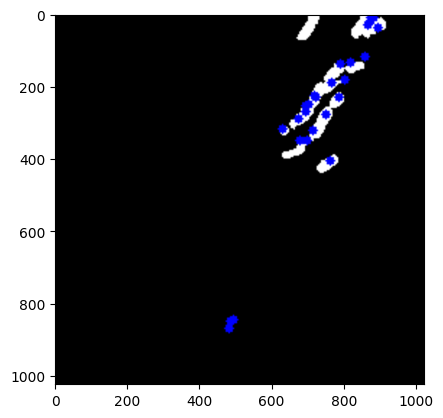

In [13]:
# create output with centroids
predict_numpy = predict.squeeze().cpu().numpy()
centroids = find_centroids(predict_numpy)
out_pred_cen = put_centroid_centers(stack(predict_numpy), centroids)
plt.imshow(out_pred_cen[0])

<h2> Local kernel maxima

# create output with local maxima
pred = predict[:,:,:,0].copy()
maxima = find_maxima(pred)
out_pred_max = put_maxima_centers(pred, centroids)

<h2> Video

In [18]:
def RAD_COLOR_FRAME(i, input, prediction_array, draw_ellipses=0, draw_predictions=True, ellipses_array=0):
    # convert to uint8
    in1 = np.uint8(input[i, :, :, 0:3] * 255)
    in2 = np.uint8(input[i + 1, :, :, 0:3] * 255)
    in3 = np.uint8(input[i + 2, :, :, 0:3] * 255)
    in4 = np.uint8(input[i + 3, :, :, 0:3] * 255)
    in5 = np.uint8(input[i + 4, :, :, 0:3] * 255)

    # in1=input[i,:,:,0:3]
    # in2=input[i+1,:,:,0:3]
    # in3=input[i+2,:,:,0:3]
    # in4=input[i+3,:,:,0:3]
    # in5=input[i+4,:,:,0:3]

    #convert to rgb
    in1 = cv2.cvtColor(in1, cv2.COLOR_BGR2RGB)
    in2 = cv2.cvtColor(in2, cv2.COLOR_BGR2RGB)
    in3 = cv2.cvtColor(in3, cv2.COLOR_BGR2RGB)
    in4 = cv2.cvtColor(in4, cv2.COLOR_BGR2RGB)
    in5 = cv2.cvtColor(in5, cv2.COLOR_BGR2RGB)

    # create masks
    bool2 = (in2 < 125) | (in2 > 129)
    mask2 = np.uint8(np.zeros((256, 256)))
    mask2[bool2[:, :, 0]] = 200
    bool3 = (in3 < 125) | (in3 > 129)
    mask3 = np.uint8(np.zeros((256, 256)))
    mask3[bool3[:, :, 0]] = 200
    bool4 = (in4 < 125) | (in4 > 129)
    mask4 = np.uint8(np.zeros((256, 256)))
    mask4[bool4[:, :, 0]] = 200
    bool5 = (in5 < 125) | (in5 > 129)
    mask5 = np.uint8(np.zeros((256, 256)))
    mask5[bool5[:, :, 0]] = 200

    mask2 = Image.fromarray(mask2)
    mask3 = Image.fromarray(mask3)
    mask4 = Image.fromarray(mask4)
    mask5 = Image.fromarray(mask5)

    in1 = Image.fromarray(in1)
    in2 = Image.fromarray(in2)
    in3 = Image.fromarray(in3)
    in4 = Image.fromarray(in4)
    in5 = Image.fromarray(in5)

    in1.paste(in2, (0, 0), mask2)
    # in1.paste(in3, (0,0), mask3)
    # in1.paste(in4, (0,0), mask4)
    # in1.paste(in5, (0,0), mask5)

    frame = np.asarray(in1)

    if draw_predictions == True:
        # draw output prediction
        print(f"shape={prediction_array.shape}, dtype={prediction_array.dtype}")
        predcopy = cv2.cvtColor(prediction_array.transpose(1, 2, 0), cv2.COLOR_BGR2RGB)
        frame[predcopy > 0] = frame[predcopy > 0] + 30
    #     if draw_ellipses == True:
    #         # draw ellipses
    #         for j in range(len(ellipses_array[i])):
    #             frame = cv2.ellipse(frame, (ellipses_array[i][j][0], ellipses_array[i][j][1]), (ellipses_array[i][j][2], ellipses_array[i][j][3]), ellipses_array[i][j][4], 0,360, (255,255,0), 1)

    frame = Image.fromarray(frame)
    frame = frame.resize((1024, 1024))
    #     time = datetime.strptime(re.search('--(.*)_', os.path.basename(files[files_index[i]])).group(1).replace('-', ' '), '%Y%m%d %H%M%S')
    #     I1 = ImageDraw.Draw(frame)
    #     I1.text((20,20), time.strftime('%Y%m%d %H%M%S'), font=ImageFont.truetype("verdanab.ttf", 30))
    #     I1.text((20,60), str(i), fill=(255), font=ImageFont.truetype("verdanab.ttf", 30))
    frame = np.asarray(frame)

    return frame

In [19]:
# make a video with ellipses
framesize = (1024, 1024)
out = cv2.VideoWriter('plots_video_ellipses.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 5, framesize, True)
for img in out_pred_ell:
    img = Image.fromarray(img.astype(np.uint8))
    img = img.resize((1024, 1024))
    out.write(np.array(img))

out.release()

In [ ]:
# def RAD_COLOR_FRAME(i, input, prediction_array, draw_ellipses=0, draw_predictions=True, ellipses_array=0):
i = 0
prediction_array = predict.cpu().numpy()
draw_ellipses = 0
draw_predictions = True
ellipses_array = 0

# convert to uint8
in1 = np.uint8(input[i, :, :, 0:3] * 255)
in2 = np.uint8(input[i + 1, :, :, 0:3] * 255)
in3 = np.uint8(input[i + 2, :, :, 0:3] * 255)
in4 = np.uint8(input[i + 3, :, :, 0:3] * 255)
in5 = np.uint8(input[i + 4, :, :, 0:3] * 255)

# in1=input[i,:,:,0:3]
# in2=input[i+1,:,:,0:3]
# in3=input[i+2,:,:,0:3]
# in4=input[i+3,:,:,0:3]
# in5=input[i+4,:,:,0:3]

#convert to rgb
in1 = cv2.cvtColor(in1, cv2.COLOR_BGR2RGB)
in2 = cv2.cvtColor(in2, cv2.COLOR_BGR2RGB)
in3 = cv2.cvtColor(in3, cv2.COLOR_BGR2RGB)
in4 = cv2.cvtColor(in4, cv2.COLOR_BGR2RGB)
in5 = cv2.cvtColor(in5, cv2.COLOR_BGR2RGB)

# create masks
bool2 = (in2 < 125) | (in2 > 129)
mask2 = np.uint8(np.zeros((256, 256)))
mask2[bool2[:, :, 0]] = 200
bool3 = (in3 < 125) | (in3 > 129)
mask3 = np.uint8(np.zeros((256, 256)))
mask3[bool3[:, :, 0]] = 200
bool4 = (in4 < 125) | (in4 > 129)
mask4 = np.uint8(np.zeros((256, 256)))
mask4[bool4[:, :, 0]] = 200
bool5 = (in5 < 125) | (in5 > 129)
mask5 = np.uint8(np.zeros((256, 256)))
mask5[bool5[:, :, 0]] = 200

mask2 = Image.fromarray(mask2)
mask3 = Image.fromarray(mask3)
mask4 = Image.fromarray(mask4)
mask5 = Image.fromarray(mask5)

in1 = Image.fromarray(in1)
in2 = Image.fromarray(in2)
in3 = Image.fromarray(in3)
in4 = Image.fromarray(in4)
in5 = Image.fromarray(in5)

in1.paste(in2, (0, 0), mask2)
# in1.paste(in3, (0,0), mask3)
# in1.paste(in4, (0,0), mask4)
# in1.paste(in5, (0,0), mask5)


frame = np.asarray(in1)

if draw_predictions == True:
    # draw output prediction
    print(f"shape={prediction_array.shape}, dtype={prediction_array.dtype}")
    predcopy = cv2.cvtColor(prediction_array.transpose(1, 2, 0), cv2.COLOR_BGR2RGB)
    frame[predcopy > 0] = frame[predcopy > 0] + 30
#     if draw_ellipses == True:
#         # draw ellipses
#         for j in range(len(ellipses_array[i])):
#             frame = cv2.ellipse(frame, (ellipses_array[i][j][0], ellipses_array[i][j][1]), (ellipses_array[i][j][2], ellipses_array[i][j][3]), ellipses_array[i][j][4], 0,360, (255,255,0), 1)


frame = Image.fromarray(frame)
frame = frame.resize((1024, 1024))
#     time = datetime.strptime(re.search('--(.*)_', os.path.basename(files[files_index[i]])).group(1).replace('-', ' '), '%Y%m%d %H%M%S')
#     I1 = ImageDraw.Draw(frame)
#     I1.text((20,20), time.strftime('%Y%m%d %H%M%S'), font=ImageFont.truetype("verdanab.ttf", 30))
#     I1.text((20,60), str(i), fill=(255), font=ImageFont.truetype("verdanab.ttf", 30))
frame = np.asarray(frame)

shape=(188, 1, 256, 256), dtype=float32


In [21]:
# make a video
framesize = (1024, 1024)
out = cv2.VideoWriter('model_ppi_video.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 5, framesize, True)
for i, img in enumerate(predict.cpu().numpy()):
    if i + 5 >= input.shape[0]:
        break

    out.write(RAD_COLOR_FRAME(i, input, img))

out.release()

shape=(1, 256, 256), dtype=float32


ValueError: assignment destination is read-only

In [90]:
pred.shape

(188, 256, 256)

In [86]:
# make a video with stacked model
pred_stack = stack(pred)

framesize = (1024, 1024)
out = cv2.VideoWriter('model_ppi_video_stack.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 5, framesize, True)
for i, img in enumerate(pred_stack):
    if i + 5 >= input.shape[0]:
        break

    out.write(RAD_COLOR_FRAME(i, input, img))

out.release()

shape=(256, 256)


ValueError: assignment destination is read-only

<h1> Tests

In [ ]:
test = predict[:, :, :, 0].copy()
ppi = input[:, :, :, 0:3].copy()

In [ ]:
test[test < 0.3] = 0

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(predict[0])

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(predict[0])

In [ ]:
tt = cv2.cvtColor(test[0], cv2.COLOR_BGR2RGB)
ppi[0][tt > 0.2] = ppi[0][tt > 0.2] + 0.1

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(ppi[0])

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(out_pred_cen[43])

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(out_pred_ell[43])